# MiniGrid settings

## Basic Jupyter Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

## Initial set-up

Import libraries and classes:

In [2]:
# Imports
import time
import io
import os
import glob
import torch
import base64
# import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt
from random import randint 

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the video function:

In [3]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_animation(experiment):
    giflist = glob.glob('animation/*.gif')
    if len(giflist) > 0:
        matching = [s for s in giflist if experiment in s]
        gif_path = matching[0]
        b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
        display.display(HTML(f'<img src="data:image/gif;base64,{b64}" height="400" />'))
    else:
        print("Could not find animation")

Define the rendering wrappers:

In [3]:
from gym.wrappers import Monitor

# Define wrapper for CNN Policy
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

def gen_wrapped_env_cnn(env_name):
    return wrap_env(ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name))))

Render an environment image:

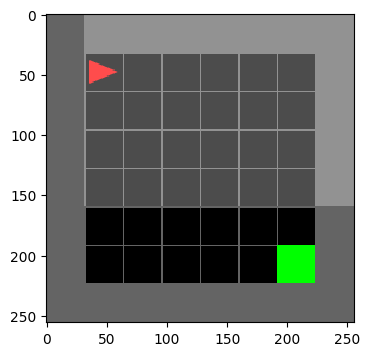

In [15]:
from random import randint
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-Empty-16x16-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'BreakoutNoFrameskip-v4'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id =  'MiniGrid-KeyCorridorS3R1-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
#random_action = eval_env.action_space.sample()
#new_obs, reward, done, info = eval_env.step(random_action)

before_img = eval_env.render('rgb_array')

plt.figure(figsize = (4.,4.))
plt.imshow(before_img);

# Standard PPO learning

## Define the environments

### Import libraries

In [5]:
import time
import io
import os
import glob
import base64
import datetime
import torch
import torch_ac
import tensorboardX
import sys
import utils
from model import ACModel
from torch_ac.utils import DictList, ParallelEnv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

### Helper functions

In [6]:
def make_envs(env_id, procs, seed=None):
    envs = []
    for i in range(procs):
        if seed:
            e = utils.make_env(env_id, seed + 10000 * i)
        else:
            e = utils.make_env(env_id)
        envs.append(e)
    env = ParallelEnv(envs)
    return env

### Render Parallel environment snapshot

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

procs = 16
max_tasks = 20
seed_list = range(procs * max_tasks, (procs + 1) * max_tasks)

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-LavaCrossingS9N2-v0'

seed = 1
env = make_envs(env_id, procs, seed)
obs = env.reset()

im_list = []
for e in env.envs:
    #print(type(e.render('rgb_array')))
    #e.reset()
    im_list.append(e.render('rgb_array'))

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

#plt.show()


## Configuration

### Load parameters

In [7]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#model = 'MiniGrid-WallGapS6-v0_PPO_frames_600k_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-DoorKey-6x6-v0'
model = 'test_ppo_frames_128_doorkey_wallgap_crossing'
processes = 16
frames = 1e6

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':1, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
'reshape_reward':False
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

### Initial settings

In [8]:
# Set run dir

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False}

Device: cpu



### Load environments, model, algo and prepare training settings

In [9]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, reshape_reward)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Optimizer loaded



## Training

In [10]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average parameters
threshold = 0.90
window = 10
rreturn_total = 0
i = 0

while num_frames < args.frames:
    # Update model parameters

    update_start_time = time.time()
    exps, logs1 = algo.collect_experiences()
    logs2 = algo.update_parameters(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        rreturn_total +=return_per_episode['mean']
        i+=1
        if i >= window:
            rreturn_mavg = rreturn_total / i
            if rreturn_mavg >= threshold:
                break_flag = True 
                break
            else:
                i = 0
                rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        #header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        #data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

print("Number of frames: ", num_frames)

U 1 | F 002048 | FPS 2452 | D 0 | rR:μσmM 0.00 0.00 0.00 0.00 | F:μσmM 0.0 0.0 0 0 | H 1.935 | V -0.089 | pL -0.047 | vL 0.002 | ∇ 0.031
U 2 | F 004096 | FPS 2778 | D 1 | rR:μσmM 0.00 0.00 0.00 0.00 | F:μσmM 0.0 0.0 0 0 | H 1.929 | V -0.062 | pL -0.030 | vL 0.000 | ∇ 0.008
U 3 | F 006144 | FPS 2474 | D 2 | rR:μσmM 0.02 0.08 0.00 0.33 | F:μσmM 354.3 22.0 269.0 360.0 | H 1.930 | V -0.023 | pL -0.037 | vL 0.001 | ∇ 0.010
U 4 | F 008192 | FPS 2442 | D 3 | rR:μσmM 0.02 0.08 0.00 0.33 | F:μσmM 354.3 22.0 269.0 360.0 | H 1.938 | V -0.015 | pL -0.009 | vL 0.000 | ∇ 0.004
U 5 | F 010240 | FPS 2913 | D 3 | rR:μσmM 0.00 0.00 0.00 0.00 | F:μσmM 360.0 0.0 360.0 360.0 | H 1.942 | V -0.006 | pL -0.006 | vL 0.000 | ∇ 0.003
U 6 | F 012288 | FPS 2812 | D 4 | rR:μσmM 0.00 0.00 0.00 0.00 | F:μσmM 360.0 0.0 360.0 360.0 | H 1.943 | V -0.004 | pL -0.003 | vL 0.000 | ∇ 0.004
U 7 | F 014336 | FPS 2369 | D 5 | rR:μσmM 0.04 0.17 0.00 0.72 | F:μσmM 344.6 59.8 113.0 360.0 | H 1.938 | V 0.011 | pL -0.014 | vL 0.005

## Evaluation

### Load parameters

In [11]:
from torch_ac.utils.penv import ParallelEnv

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 2, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False, 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



### Set environments, agent and logs, run agent and print results

In [12]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-DoorKey-6x6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 4069.0 | FPS 3987 | D 1.0 | R:μσmM 0.90 0.07 0.54 0.97 | F:μσmM 39.1 28.8 13.0 186.0


## Visualization

### Load parameters

In [ ]:
import array2gif
from pathlib import Path
import numpy

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':args.model,
'seed':15,
'shift':0,
'argmax':False,
'pause':0.1,
'gif':args.model,
'episodes':5,
# Model Parameters
'use_rim':args.use_rim,
'num_units':args.num_units,
'k':args.k
}

args = DictList(args)
print(args)

### Set environment, agent and logs

In [ ]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environment

env = utils.make_env(args.env, args.seed)
for _ in range(args.shift):
    env.reset()
print("Environment loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax, use_rim = args.use_rim, num_units = args.num_units, k = args.k)

print("Agent loaded\n")

### Make animation

In [ ]:
%%capture
# Run the agent

if args.gif:
   from array2gif import write_gif
   frames = []

# Create a window to view the environment
env.render('human')

for episode in range(args.episodes):
    obs = env.reset()
    done2 = False
    while True:
        env.render('human')
        if args.gif:
            frames.append(numpy.moveaxis(env.render("rgb_array"), 2, 0))
            

        action = agent.get_action(obs)
        obs, reward, done, _ = env.step(action)
        agent.analyze_feedback(reward, done)
        
        if done or env.window.closed:
            if episode == 4:
                done2 = True
            break
    if done2 == True:
        env.close()
        break
    #if env.window.closed:
    #    break
print('doneeee')
if args.gif:
    print("Saving gif... ", end="")
    utils.create_folders_if_necessary("./animation")
    #Path("./animation").mkdir(parents=True, exist_ok=True)
    write_gif(numpy.array(frames), "./animation/"+args.gif+".gif")
    print("Done.")

In [ ]:
show_animation(args.model)

### Make video

In [ ]:
test_env = wrap_env(env)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
    action = agent.get_action(observation)
    observation, reward, done, info = test_env.step(action)
    episode_reward += reward
    episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

# Continue learning on 2nd environment

## Configuration

### Set general parameters

In [13]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

#model = 'MiniGrid-DoorKey-6x6-v0_meta_RIM_5_3_frames_500k_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_newloop_changeseed'

add_frames = 300000
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':1, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
'reshape_reward':False
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

### Load previous loggers and settings

In [14]:
date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-WallGapS6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1300000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False}

Device: cpu



### Load existing environments, model and training status

In [15]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space, envs[0].action_space, args.mem, args.text)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, reshape_reward)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Optimizer loaded



## Continue training

In [16]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average parameters
threshold = 0.90
window = 10
rreturn_total = 0
i = 0

while num_frames < args.frames:
    # Update model parameters

    update_start_time = time.time()
    exps, logs1 = algo.collect_experiences()
    logs2 = algo.update_parameters(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        rreturn_total +=return_per_episode['mean']
        i+=1
        if i >= window:
            rreturn_mavg = rreturn_total / i
            if rreturn_mavg >= threshold:
                break_flag = True 
                break
            else:
                i = 0
                rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        #header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        #data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

print("Number of frames: ", num_frames)

U 121 | F 247808 | FPS 2663 | D 0 | rR:μσmM 0.64 0.34 0.00 0.99 | F:μσmM 27.5 27.9 0.0 92.0 | H 1.557 | V 0.460 | pL 0.163 | vL 0.012 | ∇ 0.188
U 122 | F 249856 | FPS 2945 | D 1 | rR:μσmM 0.35 0.42 0.00 0.97 | F:μσmM 95.2 59.3 5.0 144.0 | H 1.603 | V 0.301 | pL 0.146 | vL 0.029 | ∇ 0.178
U 123 | F 251904 | FPS 2964 | D 2 | rR:μσmM 0.40 0.41 0.00 0.95 | F:μσmM 88.0 58.8 8.0 144.0 | H 1.725 | V 0.205 | pL 0.089 | vL 0.014 | ∇ 0.133
U 124 | F 253952 | FPS 2649 | D 2 | rR:μσmM 0.33 0.37 0.00 0.93 | F:μσmM 98.9 52.6 11.0 144.0 | H 1.688 | V 0.186 | pL 0.054 | vL 0.018 | ∇ 0.107
U 125 | F 256000 | FPS 2909 | D 3 | rR:μσmM 0.54 0.34 0.00 0.91 | F:μσmM 70.2 49.4 14.0 144.0 | H 1.676 | V 0.236 | pL -0.056 | vL 0.031 | ∇ 0.157
U 126 | F 258048 | FPS 2766 | D 4 | rR:μσmM 0.56 0.37 0.00 0.98 | F:μσmM 66.3 54.1 3.0 144.0 | H 1.697 | V 0.254 | pL 0.001 | vL 0.033 | ∇ 0.163
U 127 | F 260096 | FPS 2823 | D 5 | rR:μσmM 0.48 0.37 0.00 0.91 | F:μσmM 78.4 52.1 15.0 144.0 | H 1.705 | V 0.206 | pL -0.010 | 

## Evaluate 2nd environment

### Load parameters

In [17]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-WallGapS6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 2, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1300000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False, 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



### Set environments, agent and logs, run agent and print results

In [18]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-WallGapS6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 1558.0 | FPS 2908 | D 0.0 | R:μσmM 0.90 0.04 0.76 0.99 | F:μσmM 16.0 7.0 2.0 38.0


# Re-evaluate 1st environment and test CF

## Evaluation

### Load parameters

In [19]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

#args.model = 'test_ppo_frames_128_doorkey_wallgap'
#args.model = 'test_ppo_frames_128_wallgap_doorkey'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 3, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1300000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False, 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



### Set environments, agent and logs, run agent and print results

In [20]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-DoorKey-6x6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 12416.0 | FPS 2938 | D 4.0 | R:μσmM 0.67 0.30 0.00 0.95 | F:μσmM 126.2 107.3 18.0 360.0


# Continue learning on 3rd environment

In [21]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
env_id = 'MiniGrid-SimpleCrossingS9N2-v0'

#model = 'MiniGrid-DoorKey-6x6-v0_meta_RIM_5_3_frames_500k_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_newloop_changeseed'
model = 'test_ppo_frames_128_doorkey_wallgap_crossing'

add_frames = 300000
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':1, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
'reshape_reward':False
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

In [22]:
date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-SimpleCrossingS9N2-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1600000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False}

Device: cpu



In [23]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space, envs[0].action_space, args.mem, args.text)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, reshape_reward)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Optimizer loaded



In [24]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average parameters
threshold = 0.90
window = 10
rreturn_total = 0
i = 0

while num_frames < args.frames:
    # Update model parameters

    update_start_time = time.time()
    exps, logs1 = algo.collect_experiences()
    logs2 = algo.update_parameters(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        rreturn_total +=return_per_episode['mean']
        i+=1
        if i >= window:
            rreturn_mavg = rreturn_total / i
            if rreturn_mavg >= threshold:
                break_flag = True 
                break
            else:
                i = 0
                rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        #header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        #data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

print("Number of frames: ", num_frames)

U 161 | F 329728 | FPS 2531 | D 0 | rR:μσmM 0.37 0.42 0.00 0.93 | F:μσmM 24.6 34.0 0.0 95.0 | H 1.649 | V 0.515 | pL 0.174 | vL 0.014 | ∇ 0.203
U 162 | F 331776 | FPS 2460 | D 1 | rR:μσmM 0.63 0.34 0.00 0.94 | F:μσmM 66.3 61.3 0.0 213.0 | H 1.731 | V 0.367 | pL 0.142 | vL 0.007 | ∇ 0.135
U 163 | F 333824 | FPS 2721 | D 2 | rR:μσmM 0.29 0.34 0.00 0.89 | F:μσmM 238.1 105.7 40.0 324.0 | H 1.758 | V 0.273 | pL 0.107 | vL 0.020 | ∇ 0.139
U 164 | F 335872 | FPS 2527 | D 3 | rR:μσmM 0.67 0.24 0.00 0.89 | F:μσmM 118.1 78.8 40.0 324.0 | H 1.755 | V 0.271 | pL -0.002 | vL 0.016 | ∇ 0.104
U 165 | F 337920 | FPS 2962 | D 3 | rR:μσmM 0.65 0.26 0.00 0.94 | F:μσmM 124.7 89.1 20.0 324.0 | H 1.737 | V 0.272 | pL 0.003 | vL 0.021 | ∇ 0.102
U 166 | F 339968 | FPS 2954 | D 4 | rR:μσmM 0.55 0.34 0.00 0.94 | F:μσmM 156.4 110.1 20.0 324.0 | H 1.755 | V 0.232 | pL 0.023 | vL 0.014 | ∇ 0.102
U 167 | F 342016 | FPS 2943 | D 5 | rR:μσmM 0.46 0.37 0.00 0.91 | F:μσmM 180.2 117.8 33.0 324.0 | H 1.769 | V 0.201 | pL

## Evaluate 3rd environment

In [25]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
env_id = 'MiniGrid-SimpleCrossingS9N2-v0'

#args.model = 'test_ppo_frames_128_wallgap_doorkey_crossing_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-SimpleCrossingS9N2-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 2, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1600000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False, 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



In [26]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-SimpleCrossingS9N2-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 3831.0 | FPS 3239 | D 1.0 | R:μσmM 0.89 0.06 0.57 0.95 | F:μσmM 38.3 23.2 18.0 156.0


# Re-evaluate 1st environment and test CF

In [27]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

#args.model = 'test_ppo_frames_128_wallgap_doorkey_crossing_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)


# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 3, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1600000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False, 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



In [28]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-DoorKey-6x6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 20909.0 | FPS 4331 | D 4.0 | R:μσmM 0.46 0.31 0.00 0.95 | F:μσmM 206.1 112.1 20.0 360.0


# Re-evaluate 2nd environment and test CF

In [29]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

#args.model = 'test_ppo_frames_128_wallgap_doorkey_crossing_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)


# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-WallGapS6-v0', 'model': 'test_ppo_frames_128_doorkey_wallgap_crossing', 'seed': 3, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1600000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'reshape_reward': False, 'mem': False, 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



In [30]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-WallGapS6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 1759.0 | FPS 3224 | D 0.0 | R:μσmM 0.90 0.06 0.70 0.98 | F:μσmM 16.7 8.9 3.0 48.0
